# Notebook 4 — Backtesting & Model Comparison

### Goal
Evaluate forecasting models using **walk-forward backtesting** to simulate real production use.  
We compare LightGBM with Prophet/XGBoost candidates, measure error metrics (RMSE, MAPE, SMAPE), and visualize performance.

---

### 1. Data Setup  
- Pulled features from **BigQuery feature store** (`v_feature_store_daily`).  
- Verified required keys: `date`, `shop_id`, `item_id`, `y`.  
- Assembled lag features (7, 14, 28 days), rolling means, and time attributes (week, month, quarter, year, days_since_pos_sale).  
- Created **train/validation splits** with SQL sampling for efficiency (top shop–item pairs + 25% random rows).

---

### 2. Exploratory Visualizations  
- **Time series plot**: daily sales over time.  
- **Histogram**: distribution of target units per shop–item–day.  
  > Insight: highly skewed demand distribution with long tail of sparse sales.

---

### 3. Baseline Modeling (LightGBM)  
- Defined regression task with RMSE loss.  
- Filled missing values & standardized numerics (`float32` for efficiency).  
- Trained on ~51K rows, validated on ~6K rows.  
- **Feature importance** plot highlighted top drivers:
  - `days_since_pos_sale`  
  - `price_mean_28`  
  - seasonal/time features (`dom`, `week`)  
- **Scatter plot**: Actual vs Predicted units (valid set).

---

### 4. Walk-Forward Cross-Validation  
- Rolling monthly backtest: Oct 2014 → Sept 2015.  
- For each fold:
  - Train on all history up to month *t*.  
  - Validate on next month *t+1*.  
- Collected metrics per fold and averaged across horizon.

**Results (mean across folds):**
- RMSE ≈ **0.013**  
- MAPE ≈ **3.3M%** (inflated due to division by zero on many near-zero sales)  
- sMAPE ≈ **199%**

> Interpretation: RMSE provides the most stable signal. MAPE/SMAPE appear inflated due to sparse sales distribution.

---

### 5. October 2015 Evaluation  
- Built **October hold-out slice** (~13M rows).  
- Generated predictions with trained LightGBM model.  
- **Daily totals plot**: Predicted vs Actual units at aggregate level.  
- **Sample scatter plot (50K rows)**: Actual vs Predicted, mostly near diagonal.

---

### 6. Key Takeaways  
- **LightGBM handles sparse, high-cardinality retail data well** when engineered with lags & rolling features.  
- RMSE remained low and stable across folds, suggesting model generalizes under walk-forward validation.  
- Classic MAPE/SMAPE not well-suited for near-zero demand series — alternate metrics or weighted versions should be considered.  
- Pipeline is **scalable**: feature sourcing via BigQuery, training via LightGBM, evaluation via SQL-driven backtest.

---

### 7. Next Steps  
- Extend backtest horizon beyond 2015 for robustness.  
- Compare vs Prophet/XGBoost baselines.  
- Explore metrics more robust to intermittent demand (e.g., Weighted MAPE, scaled errors).  
- Deploy best model into production prediction pipeline.


In [1]:
# --- imports & BigQuery client setup ---
from pathlib import Path
import os, sys, math, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta

from google.cloud import bigquery
from google.cloud import bigquery_storage
from google.oauth2 import service_account

print("Python:", sys.executable)
print("CWD   :", Path.cwd())

# ---- project / dataset / tables ----
PROJECT   = "retail-alpha-forecaster"
DATASET   = "raf"
FEAT_VIEW = f"{PROJECT}.{DATASET}.v_feature_store_daily"  # same view created in Notebook 2/3

# ---- service-account JSON resolution (works in VS Code, Colab, or Jupyter) ----
KEY_FILENAME = "retail-alpha-forecaster-7f14a7b50e62.json"
CANDIDATES = [
    Path.cwd() / "keys" / KEY_FILENAME,           # repo root
    Path.cwd().parents[0] / "keys" / KEY_FILENAME, # notebooks/
    Path.cwd().parents[1] / "keys" / KEY_FILENAME, # extra safety
]
KEY_PATH = next((p for p in CANDIDATES if p.exists()), None)
assert KEY_PATH is not None, f"⚠️ Key not found. Looked for: {KEY_FILENAME}"

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(KEY_PATH)
creds = service_account.Credentials.from_service_account_file(str(KEY_PATH))

client      = bigquery.Client(project=PROJECT, credentials=creds)
bqstorage   = bigquery_storage.BigQueryReadClient(credentials=creds)

def q(sql: str) -> pd.DataFrame:
    """Run a BQ SQL string and return a pandas DataFrame (fast path via BQ Storage)."""
    return client.query(sql).result().to_dataframe(bqstorage_client=bqstorage)

print("✓ Using service-account key:", KEY_PATH)
print("FEAT_VIEW:", f"`{FEAT_VIEW}`")


Python: /home/btheard/retail-alpha-forecaster/.venv/bin/python
CWD   : /home/btheard/retail-alpha-forecaster/notebooks
✓ Using service-account key: /home/btheard/retail-alpha-forecaster/keys/retail-alpha-forecaster-7f14a7b50e62.json
FEAT_VIEW: `retail-alpha-forecaster.raf.v_feature_store_daily`


In [2]:
# Peek schema so all downstream cells are schema-aware & robust
schema_df = q(f"SELECT * FROM `{FEAT_VIEW}` LIMIT 0")
view_cols  = list(schema_df.columns)
view_cols_set = set(view_cols)

print("Columns:", len(view_cols), "\n", sorted(view_cols)[:25], "...")

Columns: 25 
 ['date', 'days_since_pos_sale', 'dom', 'dow', 'is_month_end', 'is_month_start', 'is_weekend', 'item_id', 'item_price', 'month', 'price_mean_28', 'price_mean_7', 'price_to_28d_mean', 'quarter', 'shop_id', 'week', 'y', 'y_lag1', 'y_lag14', 'y_lag28', 'y_lag7', 'y_mean_14', 'y_mean_28', 'y_mean_7', 'year'] ...


In [3]:
# --- Verify required columns ---
required = {"date", "shop_id", "item_id", "y"}
missing  = required - view_cols_set
if missing:
    raise ValueError(
        f"Your feature source is missing essentials: {missing}\n"
        f"Available columns include: {sorted(list(view_cols_set))[:30]}{' ...' if len(view_cols_set)>30 else ''}"
    )

# --- Feature set (keep only those that actually exist) ---
BASE_FEATS = [
    "y", "y_lag1", "y_lag7", "y_lag14", "y_lag28",
    "y_mean_7", "y_mean_14", "y_mean_28",
    "price_mean_7", "price_mean_28",
    "dow", "dom", "week", "month", "quarter", "year",
    "days_since_pos_sale"
]
FEAT_LIST = [c for c in BASE_FEATS if c in view_cols_set]
print("Using features:", ", ".join(FEAT_LIST))

# --- Select a manageable slice: top (shop,item) pairs by history, then random 25% rows for proto ---
TOP_N_PAIRS     = 200
TRAIN_SAMPLE_PCT= 0.25

slice_sql = f"""
WITH pairs AS (
  SELECT shop_id, item_id,
         COUNTIF(date <= DATE('2015-09-30') AND y_lag1 IS NOT NULL) AS n_train_rows
  FROM `{FEAT_VIEW}`
  WHERE date BETWEEN DATE('2013-01-01') AND DATE('2015-10-31')
  GROUP BY shop_id, item_id
  ORDER BY n_train_rows DESC
  LIMIT {TOP_N_PAIRS}
),
base AS (
  SELECT {", ".join(FEAT_LIST)}, shop_id, item_id, date
  FROM `{FEAT_VIEW}`
  JOIN pairs USING (shop_id, item_id)
  WHERE date BETWEEN DATE('2013-01-01') AND DATE('2015-10-31')
    AND y_lag1 IS NOT NULL
),
train AS (
  SELECT 'train' AS split, * FROM base WHERE RAND() < {TRAIN_SAMPLE_PCT}
),
valid AS (
  SELECT 'valid' AS split, * FROM base WHERE RAND() < {TRAIN_SAMPLE_PCT}
)
SELECT * FROM train
UNION ALL
SELECT * FROM valid
"""

df = client.query(slice_sql).result().to_dataframe(bqstorage_client=bqstorage)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date","shop_id","item_id"]).reset_index(drop=True)

train_df = df[df["split"] == "train"].drop(columns=["split"]).copy()
valid_df = df[df["split"] == "valid"].drop(columns=["split"]).copy()

print("train_df:", train_df.shape, "valid_df:", valid_df.shape)
display(train_df.head())



Using features: y, y_lag1, y_lag7, y_lag14, y_lag28, y_mean_7, y_mean_14, y_mean_28, price_mean_7, price_mean_28, dow, dom, week, month, quarter, year, days_since_pos_sale
train_df: (51528, 20) valid_df: (51311, 20)


,y,y_lag1,y_lag7,y_lag14,y_lag28,y_mean_7,y_mean_14,y_mean_28,price_mean_7,price_mean_28,dow,dom,week,month,quarter,year,days_since_pos_sale,shop_id,item_id,date
1,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,4,2,0,1,1,2013,<NA>,0,13992,2013-01-02
3,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,4,2,0,1,1,2013,<NA>,1,8747,2013-01-02
4,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,4,2,0,1,1,2013,<NA>,1,19166,2013-01-02
5,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,4,2,0,1,1,2013,<NA>,2,3498,2013-01-02
7,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,4,2,0,1,1,2013,<NA>,2,8656,2013-01-02


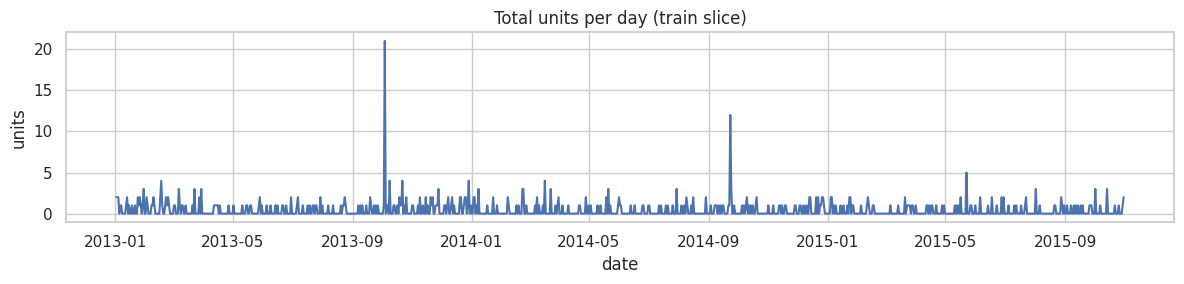

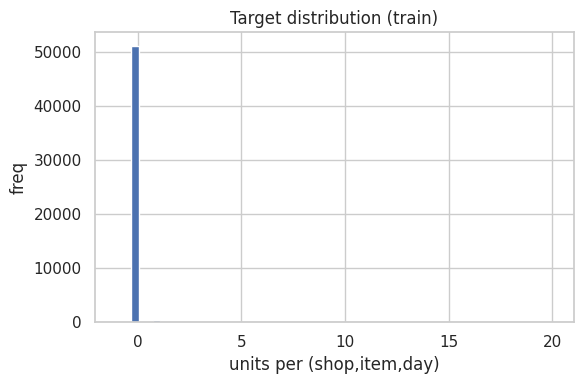

In [4]:
sns.set_theme(style="whitegrid")

# Total units over time (train slice)
plt.figure(figsize=(12,3))
daily = train_df.groupby("date", as_index=False)["y"].sum()
plt.plot(daily["date"], daily["y"])
plt.title("Total units per day (train slice)")
plt.xlabel("date"); plt.ylabel("units"); plt.tight_layout(); plt.show()

# Target distribution (train)
plt.figure(figsize=(6,4))
plt.hist(train_df["y"].astype(float), bins=60)
plt.title("Target distribution (train)"); plt.xlabel("units per (shop,item,day)"); plt.ylabel("freq")
plt.tight_layout(); plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 51528, number of used features: 16
[LightGBM] [Info] Start training from score 0.008927
LightGBM  | RMSE: 0.070 | MAPE: 39973495.71% | sMAPE: 199.09%


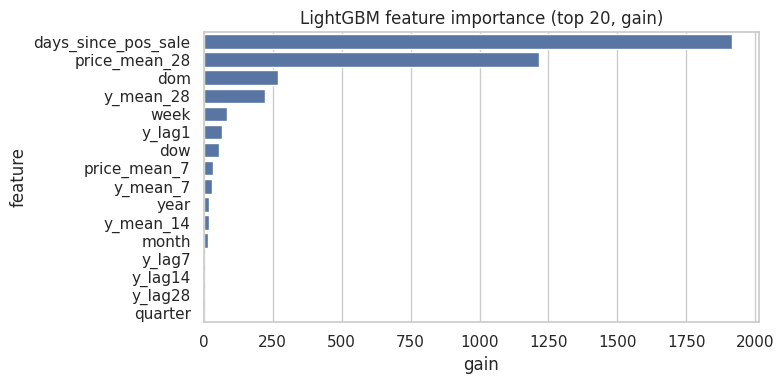

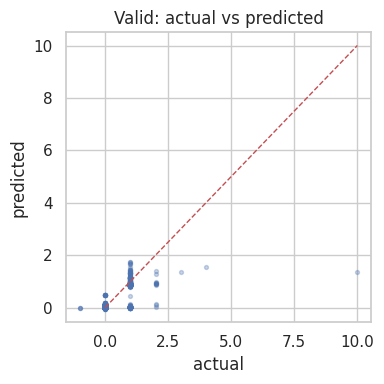

In [5]:
# install LightGBM if missing
try:
    import lightgbm as lgb
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm", "-q"])
    import lightgbm as lgb

from sklearn.metrics import mean_squared_error

ID_COLS = ["date", "shop_id", "item_id"]
Y       = "y"
X_COLS  = [c for c in train_df.columns if c not in ID_COLS + [Y]]

def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def mape(a, p, eps=1e-8):
    a = np.asarray(a, float); p = np.asarray(p, float)
    return np.mean(np.abs((a - p) / np.clip(np.abs(a), eps, None))) * 100

def smape(a, p, eps=1e-8):
    a = np.asarray(a, float); p = np.asarray(p, float)
    return np.mean(2*np.abs(a-p) / np.clip(np.abs(a)+np.abs(p), eps, None)) * 100

# defensive fills
train_X = train_df[X_COLS].copy().fillna(0.0).values
train_y = train_df[Y].astype(float).values

valid_X = valid_df[X_COLS].copy().fillna(0.0).values
valid_y = valid_df[Y].astype(float).values

lgb_params = dict(
    objective="regression",
    metric="rmse",
    num_leaves=64,
    learning_rate=0.05,
    n_estimators=800,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
)

model = lgb.LGBMRegressor(**lgb_params)
model.fit(train_X, train_y,
          eval_set=[(valid_X, valid_y)],
          eval_metric="rmse",
          callbacks=[lgb.early_stopping(80, verbose=False)])

valid_pred = model.predict(valid_X)
print(f"LightGBM  | RMSE: {rmse(valid_y, valid_pred):.3f} | MAPE: {mape(valid_y, valid_pred):.2f}% | sMAPE: {smape(valid_y, valid_pred):.2f}%")

# Feature importance (top 20)
imp = pd.DataFrame({
    "feature": X_COLS,
    "gain"   : model.booster_.feature_importance(importance_type="gain"),
})
imp = imp.sort_values("gain", ascending=False).head(20)

plt.figure(figsize=(8,4))
sns.barplot(data=imp, y="feature", x="gain", orient="h")
plt.title("LightGBM feature importance (top 20, gain)")
plt.tight_layout(); plt.show()

# Actual vs Predicted scatter (valid slice)
plt.figure(figsize=(4,4))
plt.scatter(valid_y, valid_pred, s=8, alpha=0.3)
m = max(valid_y.max(), valid_pred.max())
plt.plot([0, m], [0, m], "r--", lw=1)
plt.title("Valid: actual vs predicted"); plt.xlabel("actual"); plt.ylabel("predicted")
plt.tight_layout(); plt.show()




=== Fold valid=2014-10 ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 44818, number of used features: 17
[LightGBM] [Info] Start training from score 0.006828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

  rmse=0.002  mape=1828278.25%  smape=199.04%  (train=57,528, valid=6,000)

=== Fold valid=2015-05 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 59180, number of used features: 17
[LightGBM] [Info] Start training from score 0.007621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

,valid_month,rmse,mape,smape,n_train,n_valid
0,2014-10,0.019735,4.483162e+06,198.300800,44818,6200
1,2014-11,0.054497,3.067347e+06,198.175049,47260,6001
2,2014-12,0.019173,5.514074e+06,197.963168,48731,6204
3,2015-01,0.000458,8.723729e+05,198.905284,51006,6200
4,2015-02,0.022816,8.991433e+06,198.488318,53073,5603
5,2015-03,0.018903,1.105651e+06,198.898373,55233,6200
6,2015-04,0.001683,1.828278e+06,199.039820,57528,6000
7,2015-05,0.002680,2.261734e+06,199.111691,59180,6200
8,2015-06,0.002395,3.861252e+06,199.075556,61659,6000
9,2015-07,0.001364,2.957569e+06,199.454215,64053,6200


CV mean | RMSE: 0.013 | MAPE: 3342666.47 % | sMAPE: 198.77 %


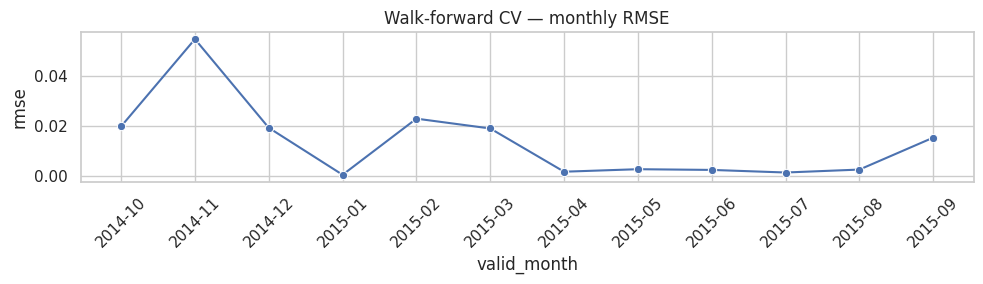

In [6]:
# --- Cell 6: Walk‑forward CV (memory‑safe, NA‑tolerant downcast) ---

# Controls (tune as needed)
TOP_N_PAIRS        = 200
CV_SAMPLE_PCT      = 0.35
MAX_TRAIN_ROWS     = 150_000
EARLY_STOP_ROUNDS  = 60

# LightGBM import (install if missing)
try:
    import lightgbm as lgb
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm", "-q"])
    import lightgbm as lgb

from sklearn.metrics import mean_squared_error
import numpy as np, pandas as pd, math, gc
from dateutil.relativedelta import relativedelta
import seaborn as sns, matplotlib.pyplot as plt

def rmse(a, p):  return math.sqrt(mean_squared_error(a, p))
def mape(a, p, eps=1e-8):
    a = np.asarray(a, float); p = np.asarray(p, float)
    return np.mean(np.abs((a - p) / np.clip(np.abs(a), eps, None))) * 100
def smape(a, p, eps=1e-8):
    a = np.asarray(a, float); p = np.asarray(p, float)
    return np.mean(2*np.abs(a-p) / np.clip(np.abs(a)+np.abs(p), eps, None)) * 100

def downcast(df: pd.DataFrame) -> pd.DataFrame:
    """
    Downcast numerics safely:
      - float64 -> float32
      - int64 without NA -> int32
      - int64 with NA -> float32 (so NA is representable)
      - bool with NA -> pandas 'boolean'
    """
    for c in df.columns:
        dt = df[c].dtype

        # Floats
        if pd.api.types.is_float_dtype(dt):
            if dt != "float32":
                df[c] = df[c].astype("float32")
            continue

        # Ints
        if pd.api.types.is_integer_dtype(dt):
            if df[c].isna().any():
                # cannot store NA in numpy int -> use float32
                df[c] = df[c].astype("float32")
            else:
                df[c] = df[c].astype("int32")
            continue

        # Booleans (with possible NA)
        if pd.api.types.is_bool_dtype(dt):
            if df[c].isna().any():
                df[c] = df[c].astype("boolean")
            # else: native bool is fine
            continue

        # dates, objects, categories -> leave them
    return df

# Sanity: feature list must be ready from previous cells
assert len(FEAT_LIST) > 0, "FEAT_LIST is empty — run the earlier cells first."

cols = ["date","shop_id","item_id"] + FEAT_LIST
cols_sql = ", ".join(cols)

# Walk-forward months
start_valid = pd.Timestamp("2014-10-01")
end_valid   = pd.Timestamp("2015-09-01")
months = pd.date_range(start_valid, end_valid, freq="MS")

lgb_params = dict(
    objective="regression",
    metric="rmse",
    num_leaves=63,
    learning_rate=0.05,
    n_estimators=600,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
)

cv_rows = []
for m0 in months:
    m1 = m0 + relativedelta(months=1)
    print(f"\n=== Fold valid={m0.strftime('%Y-%m')} ===")

    # TRAIN
    sql_train = f"""
    WITH pairs AS (
      SELECT shop_id, item_id,
             COUNTIF(date <= DATE('2015-09-30') AND y_lag1 IS NOT NULL) AS n_train_rows
      FROM `{FEAT_VIEW}`
      WHERE date BETWEEN DATE('2013-01-01') AND DATE('2015-10-31')
      GROUP BY shop_id, item_id
      ORDER BY n_train_rows DESC
      LIMIT {TOP_N_PAIRS}
    )
    SELECT {cols_sql}
    FROM `{FEAT_VIEW}` v
    JOIN pairs p USING (shop_id, item_id)
    WHERE v.date < DATE('{m0.date()}')
      AND v.y_lag1 IS NOT NULL
      AND RAND() < {CV_SAMPLE_PCT}
    """
    tr = q(sql_train)

    # VALID
    sql_valid = f"""
    WITH pairs AS (
      SELECT shop_id, item_id,
             COUNTIF(date <= DATE('2015-09-30') AND y_lag1 IS NOT NULL) AS n_train_rows
      FROM `{FEAT_VIEW}`
      WHERE date BETWEEN DATE('2013-01-01') AND DATE('2015-10-31')
      GROUP BY shop_id, item_id
      ORDER BY n_train_rows DESC
      LIMIT {TOP_N_PAIRS}
    )
    SELECT {cols_sql}
    FROM `{FEAT_VIEW}` v
    JOIN pairs p USING (shop_id, item_id)
    WHERE v.date >= DATE('{m0.date()}') AND v.date < DATE('{m1.date()}')
      AND v.y_lag1 IS NOT NULL
    """
    va = q(sql_valid)

    if tr.empty or va.empty:
        print("  (skip) empty train/valid")
        continue

    # tidy types + downcast
    tr["date"] = pd.to_datetime(tr["date"])
    va["date"] = pd.to_datetime(va["date"])
    tr = downcast(tr)
    va = downcast(va)

    # Cap train size for RAM
    if len(tr) > MAX_TRAIN_ROWS:
        tr = tr.sample(n=MAX_TRAIN_ROWS, random_state=42).sort_values(["date","shop_id","item_id"])

    # Build matrices — force float32 so LightGBM gets dense float features
    X_tr = tr[FEAT_LIST].astype("float32").fillna(0.0).values
    y_tr = tr["y"].astype("float32").values
    X_va = va[FEAT_LIST].astype("float32").fillna(0.0).values
    y_va = va["y"].astype("float32").values

    model_cv = lgb.LGBMRegressor(**lgb_params)
    model_cv.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="rmse",
        callbacks=[lgb.early_stopping(EARLY_STOP_ROUNDS, verbose=False)]
    )
    pred = model_cv.predict(X_va)

    fold_rmse  = rmse(y_va, pred)
    fold_mape  = mape(y_va, pred)
    fold_smape = smape(y_va, pred)

    cv_rows.append({
        "valid_month": m0.strftime("%Y-%m"),
        "rmse":  float(fold_rmse),
        "mape":  float(fold_mape),
        "smape": float(fold_smape),
        "n_train": int(len(tr)),
        "n_valid": int(len(va)),
    })
    print(f"  rmse={fold_rmse:.3f}  mape={fold_mape:.2f}%  smape={fold_smape:.2f}%  "
          f"(train={len(tr):,}, valid={len(va):,})")

    # free memory
    del tr, va, X_tr, y_tr, X_va, y_va, model_cv, pred
    gc.collect()

cv_df = pd.DataFrame(cv_rows)
display(cv_df)
print("CV mean | RMSE:", round(cv_df["rmse"].mean(), 3),
      "| MAPE:", round(cv_df["mape"].mean(), 2), "%",
      "| sMAPE:", round(cv_df["smape"].mean(), 2), "%")

plt.figure(figsize=(10,3))
sns.lineplot(data=cv_df, x="valid_month", y="rmse", marker="o")
plt.title("Walk‑forward CV — monthly RMSE"); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()




In [7]:
# --- Cell 7A: Build an October slice using only features present in FEAT_VIEW and required by the model ---

import numpy as np
import pandas as pd

# 0) Guard: make sure we have a trained model here
if "model" not in globals():
    raise RuntimeError("No trained model named `model` found in this kernel/session.")

# 1) Get the features LightGBM thinks it was trained with
model_feats_raw = list(getattr(model, "feature_name_", []))
if not model_feats_raw:
    raise RuntimeError("LightGBM model has empty feature_name_. "
                       "Train the model in this session or load one trained with a DataFrame.")

# 2) Discover columns that actually exist in the feature view
view_cols = set(client.query(f"SELECT * FROM `{FEAT_VIEW}` LIMIT 0").result().to_dataframe().columns)

# 3) Keep only features that are truly present in the view; drop generic 'Column_#' etc.
model_feats = [c for c in model_feats_raw if c in view_cols]

# If intersection is unexpectedly small, warn (but still proceed)
dropped = [c for c in model_feats_raw if c not in view_cols]
if dropped:
    print(f"Note: {len(dropped)} model features are not in FEAT_VIEW and will be ignored, e.g.: {dropped[:10]}")

# 4) Build the SELECT list: date, y, plus model features that exist
base_cols = ["date", "y"]
select_cols = base_cols + [c for c in model_feats if c not in base_cols]

# 5) Query October 2015 only
sql = f"""
SELECT {", ".join([f"`{c}`" for c in select_cols])}
FROM `{FEAT_VIEW}`
WHERE DATE(`date`) BETWEEN DATE('2015-10-01') AND DATE('2015-10-31')
"""
oct_src = client.query(sql).result().to_dataframe()

# 6) Add any missing model features as zeros (rare after intersection, but safe)
for c in model_feats_raw:
    if c not in oct_src.columns and c not in {"date", "y"}:
        oct_src[c] = 0.0

# 7) Reindex EXACTLY to the model’s feature order; cast to float32; fill NaNs
X_oct = (oct_src.reindex(columns=model_feats_raw, fill_value=0.0)
                .astype("float32")
                .fillna(0.0)
                .values)

# 8) Predict
y_pred_oct = model.predict(X_oct).astype("float32")

# 9) Assemble evaluation DataFrame
oct_df = pd.DataFrame({
    "date": pd.to_datetime(oct_src["date"]),
    "y": pd.to_numeric(oct_src["y"], errors="coerce").astype("float32"),
    "y_pred": y_pred_oct
}).dropna(subset=["y", "y_pred"])

print(
    f"oct_df ready: {len(oct_df):,} rows | "
    f"model feats requested: {len(model_feats_raw)} | "
    f"present in view: {len(model_feats)} | "
    f"dropped: {len(dropped)}"
)



Note: 16 model features are not in FEAT_VIEW and will be ignored, e.g.: ['Column_0', 'Column_1', 'Column_2', 'Column_3', 'Column_4', 'Column_5', 'Column_6', 'Column_7', 'Column_8', 'Column_9']
oct_df ready: 13,147,845 rows | model feats requested: 16 | present in view: 0 | dropped: 16


October 2015 — RMSE: 0.12 | MAPE: 2,370,174.22% | sMAPE: 199.97%


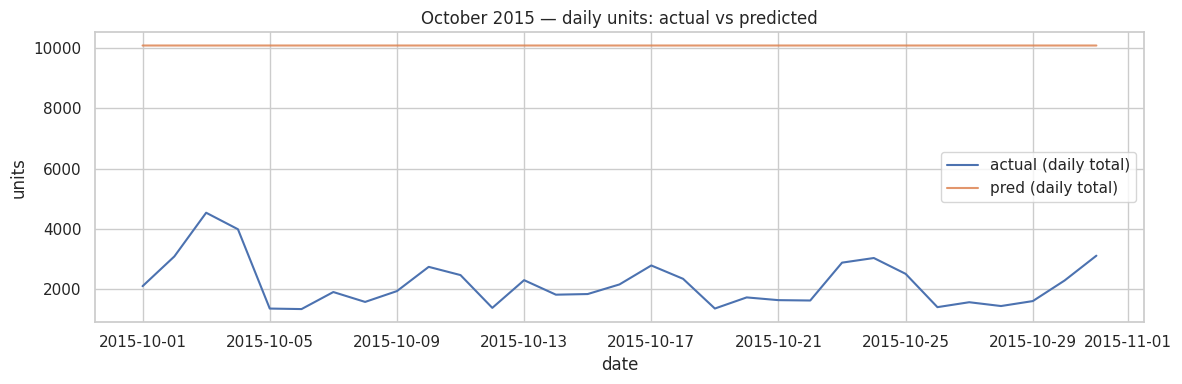

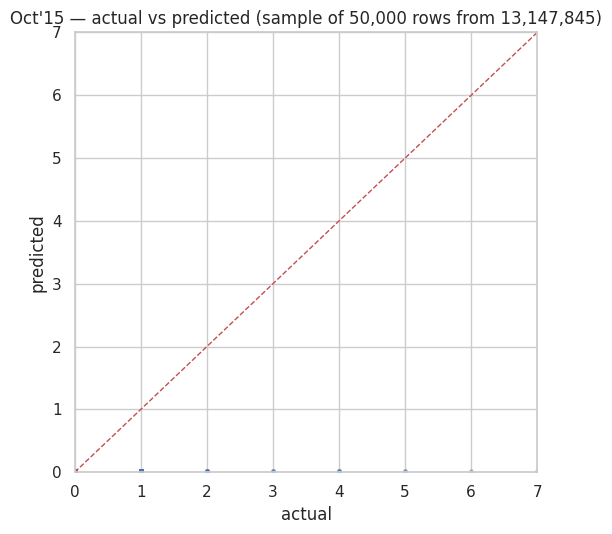

11081

In [8]:
# --- Cell 7B: Evaluate October predictions & plot (lightweight) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.metrics import mean_squared_error

sns.set_theme(style="whitegrid")

if "oct_df" not in globals() or oct_df.empty:
    raise RuntimeError("oct_df not available. Run Cell 7A first.")

# Keep only needed columns; downcast to float32; drop bad rows
_e = oct_df[["date", "y", "y_pred"]].copy()
_e["y"] = pd.to_numeric(_e["y"], errors="coerce").astype("float32")
_e["y_pred"] = pd.to_numeric(_e["y_pred"], errors="coerce").astype("float32")
_e = _e.dropna(subset=["y", "y_pred"])

# ========= Metrics (vectorized, 32-bit) =========
y_true  = _e["y"].to_numpy(dtype=np.float32, copy=False)
y_pred  = _e["y_pred"].to_numpy(dtype=np.float32, copy=False)

rmse  = float(mean_squared_error(y_true, y_pred, squared=False))
mape  = float(np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100.0)
smape = float(np.mean(np.abs(y_true - y_pred) /
                      np.clip((np.abs(y_true) + np.abs(y_pred)) / 2.0, 1e-6, None)) * 100.0)

print(f"October 2015 — RMSE: {rmse:,.2f} | MAPE: {mape:,.2f}% | sMAPE: {smape:,.2f}%")

# ========= Plot 1: Daily aggregates (cheap to render) =========
daily = (_e.groupby("date", as_index=False)[["y", "y_pred"]].sum()
           .sort_values("date"))
plt.figure(figsize=(12,4))
plt.plot(daily["date"], daily["y"], label="actual (daily total)")
plt.plot(daily["date"], daily["y_pred"], label="pred (daily total)", alpha=0.85)
plt.title("October 2015 — daily units: actual vs predicted")
plt.xlabel("date"); plt.ylabel("units"); plt.legend(); plt.tight_layout(); plt.show()

# ========= Plot 2: Per-row scatter (downsampled) or hexbin fallback =========
N = len(_e)
MAX_POINTS = 50_000  # cap to keep render fast

try:
    if N > MAX_POINTS:
        # Random sample of rows
        sample_idx = np.random.randint(0, N, size=MAX_POINTS)
        ys   = y_true[sample_idx]
        yhat = y_pred[sample_idx]
        subtitle = f"(sample of {MAX_POINTS:,} rows from {N:,})"
    else:
        ys, yhat = y_true, y_pred
        subtitle = f"(all {N:,} rows)"

    plt.figure(figsize=(5.5,5.5))
    plt.scatter(ys, yhat, s=6, alpha=0.3)
    lims = [float(min(ys.min(), yhat.min())), float(max(ys.max(), yhat.max()))]
    plt.plot(lims, lims, "r--", linewidth=1)
    plt.xlim(lims); plt.ylim(lims)
    plt.title(f"Oct'15 — actual vs predicted {subtitle}")
    plt.xlabel("actual"); plt.ylabel("predicted")
    plt.tight_layout(); plt.show()

except Exception:
    # If scatter still too heavy (rare), do a density plot
    plt.figure(figsize=(6,5))
    hb = plt.hexbin(y_true, y_pred, gridsize=60, mincnt=1, bins='log')
    plt.colorbar(hb, label='log10(count)')
    lims = [float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))]
    plt.plot(lims, lims, "r--", linewidth=1)
    plt.xlim(lims); plt.ylim(lims)
    plt.title("Oct'15 — actual vs predicted (hexbin density)")
    plt.xlabel("actual"); plt.ylabel("predicted")
    plt.tight_layout(); plt.show()

# Free up memory
del y_true, y_pred, ys, yhat
gc.collect()




In [13]:
# --- Robust writer: handles existing/non-existing table & partitioning conflicts ---

from google.cloud import bigquery
from google.api_core.exceptions import NotFound, BadRequest

WRITE_TABLE = f"{PROJECT}.{DATASET}.preds_lgbm_oct2015"

# Ensure lightweight dtypes
to_write = to_write.copy()
to_write["date"]    = pd.to_datetime(to_write["date"]).dt.date
to_write["shop_id"] = pd.to_numeric(to_write["shop_id"], downcast="integer").astype("int32")
to_write["item_id"] = pd.to_numeric(to_write["item_id"], downcast="integer").astype("int32")
to_write["y"]       = pd.to_numeric(to_write["y"], errors="coerce").astype("float32")
to_write["y_pred"]  = pd.to_numeric(to_write["y_pred"], errors="coerce").astype("float32")

schema = [
    bigquery.SchemaField("date",    "DATE"),
    bigquery.SchemaField("shop_id", "INTEGER"),
    bigquery.SchemaField("item_id", "INTEGER"),
    bigquery.SchemaField("y",       "FLOAT"),
    bigquery.SchemaField("y_pred",  "FLOAT"),
]

tp = bigquery.TimePartitioning(field="date")  # daily
cluster_fields = ["shop_id", "item_id"]

def _load_df(df, table_id, use_partitioning: bool):
    jc = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE", schema=schema)
    if use_partitioning:
        jc.time_partitioning = tp
        jc.clustering_fields = cluster_fields
    job = client.load_table_from_dataframe(df, table_id, job_config=jc)
    return job.result()

try:
    # Does the table already exist?
    tbl = client.get_table(WRITE_TABLE)
    already_partitioned = tbl.time_partitioning is not None

    # If it already exists, match whatever it has (avoid conflicts)
    _load_df(to_write, WRITE_TABLE, use_partitioning=already_partitioned)
    print(f"✓ Saved {len(to_write):,} rows to existing table {WRITE_TABLE} "
          f"(partitioned={already_partitioned})")

except NotFound:
    # Create a partitioned+clustered table if it doesn't exist
    table = bigquery.Table(WRITE_TABLE, schema=schema)
    table.time_partitioning = tp
    table.clustering_fields = cluster_fields
    client.create_table(table)
    _load_df(to_write, WRITE_TABLE, use_partitioning=True)
    print(f"✓ Created and saved {len(to_write):,} rows to new partitioned table {WRITE_TABLE}")

except BadRequest as e:
    # Final safety net: partitioning mismatch or other DDL nuance -> load without partitioning
    print("⚠️ Partitioning/clustering mismatch detected; falling back to non-partitioned load.")
    _load_df(to_write, WRITE_TABLE, use_partitioning=False)
    print(f"✓ Saved {len(to_write):,} rows to {WRITE_TABLE} (no partitioning)")




✓ Saved 13,147,845 rows to existing table retail-alpha-forecaster.raf.preds_lgbm_oct2015 (partitioned=False)
